
### LLC4320 : Comparison Eulerian and Lagrangian basics statistics (mean velocity fields)

In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5447197.datarmor0/parcels-502090/libparcels_random_9fa9e565-6955-487d-b370-5ce70756086e.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=4)
#
client = Client(cluster)



In [3]:
client

<Client: 'tcp://10.148.0.220:42737' processes=0 threads=0, memory=0 B>

### Load data

In [4]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 

#df = df.persist()

In [5]:
#ds_Lstats = p.load_diagnostic('L_dl1.0_stats.zarr')
ds_Lstats = p.load_diagnostic('L_dl1.0_stats.zarr')
ds_Lstats = ds_Lstats.compute()

In [6]:
ds_Lstats

<xarray.Dataset>
Dimensions:                            (lat: 179, lon: 359)
Coordinates:
  * lat                                (lat) float64 -89.5 -88.5 ... 87.5 88.5
  * lon                                (lon) float64 -179.5 -178.5 ... 178.5
Data variables: (12/30)
    EKE                                (lon, lat) float64 nan nan ... nan nan
    EKE_binned                         (lon, lat) float64 nan nan ... nan nan
    EKE_ibinned                        (lon, lat) float64 nan nan ... nan nan
    KE                                 (lon, lat) float64 nan nan ... nan nan
    mean_KE                            (lon, lat) float64 nan nan ... nan nan
    mean_KE_binned                     (lon, lat) float64 nan nan ... nan nan
    ...                                 ...
    zonal_velocity_binned_iprime       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_bprime              (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_bprime_square       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_iprime              (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_iprime_square       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_square              (lon, lat) float64 nan nan ... nan nan
Attributes:
    dl:        1.0
    run_name:  global_extra_T365j_dt1j_dij50

### Eulerian diagnostics

In [7]:
V = ["SSU","SSV"]#["SSU", "SSV"]
D = ["mean","variance"]
ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in D])
grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
ds = xr.merge([ds,grid])
sub = 2
ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub),i_g=slice(0,None,sub),j_g=slice(0,None,sub))
#ds = ds.where(ds.Depth>500, drop=False)
ds = ds.persist()
print(ds)

<xarray.Dataset>
Dimensions:       (face: 13, i: 2160, i_g: 2160, j: 2160, j_g: 2160)
Coordinates: (12/20)
  * face          (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g           (i_g) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
  * j             (j) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
  * i             (i) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
  * j_g           (j_g) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
    CS            (face, j, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    ...            ...
    dyC           (face, j_g, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    dyG           (face, j, i_g) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    rA            (face, j, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    rAs           (face, j_g, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    rAw           

In [8]:
ds = ds.drop(['i_g','j_g'])

ds = ds.rename({'i_g':'i','j_g':'j'})

ds = ds.compute()

In [9]:
ds['lon'] = 0*ds.face+ds.XC
ds['lat'] = 0*ds.face+ds.YC

In [10]:
ds['zonal_velocity_mean'] =  ds['mean'+'_SSU']*ds.CS - ds["mean"+'_SSV']*ds.SN
ds['meridional_velocity_mean'] =  ds['mean'+'_SSU']*ds.SN + ds["mean"+'_SSV']*ds.CS

In [11]:
ds['zonal_velocity_var'] =  ds['variance'+'_SSU']*ds.CS - ds["variance"+'_SSV']*ds.SN
ds['meridional_velocity_var'] =  np.abs(ds['variance'+'_SSU']*ds.SN + ds["variance"+'_SSV']*ds.CS)

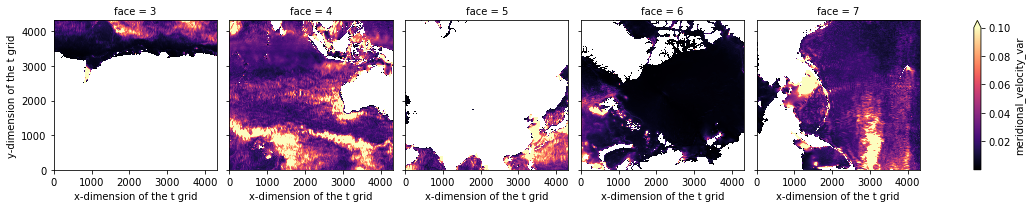

In [12]:
ds.meridional_velocity_var.isel(face=slice(3,8
                                          )).plot(col='face',vmax=0.1,cmap='magma')

#### Create xarray dataset with all faces assembled

In [13]:
ds_rot = llcreader.faces_dataset_to_latlon(ds.drop(['mean_SSU','mean_SSV','variance_SSU','variance_SSV']))

In [14]:
ds_rot = ds_rot.compute()
print(ds_rot)

<xarray.Dataset>
Dimensions:                   (face: 13, i: 8640, j: 6480)
Coordinates: (12/18)
  * face                      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                         (j) int64 0 1 2 3 4 5 ... 6475 6476 6477 6478 6479
  * i                         (i) int64 0 1 2 3 4 5 ... 8635 8636 8637 8638 8639
    CS                        (j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Depth                     (j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SN                        (j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                        ...
    rAw                       (j, i) float32 1.555e+05 1.555e+05 ... 1.141e+04
    rAz                       (j, i) float32 7.774e+04 7.775e+04 ... 1.384e+04
    dxC                       (j, i) float32 324.6 324.6 324.6 ... 156.9 124.2
    dyC                       (j, i) float32 239.5 239.5 239.5 ... 134.9 112.4
    dyG                       (j, i) float32 479.0 479.0 479.1 ... 136.3 10

In [15]:
ds_rot = ds_rot.drop([C for C in ds_rot.zonal_velocity_mean.coords][2:])
ds_rot = ds_rot.drop(['face'])


df_rot = ds_rot.to_dataframe()    

In [16]:
def binned_mean(df,dl):
    """Average dataframe over bins width dl
    
    Parameters 
    df : dataframe with at least longitude, latitude and field to bin in columns
    dl : bin width
    
    Returns
    df_mean : dataset with averaged fields
    """
    lon = np.arange(-180.,180., dl)
    lat = np.arange(-70., 70., dl)
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    df_mean = df.groupby(['lon_cut','lat_cut']).mean()
    df_mean = pa.add_geodata(df_mean)
    df_mean = (df_mean
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )
    return df_mean

In [18]:
dl = 1.
ds_Estats = binned_mean(df_rot,dl)

In [19]:
ds_Estats

<xarray.Dataset>
Dimensions:                   (lat: 139, lon: 359)
Coordinates:
  * lon                       (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
  * lat                       (lat) float64 -69.5 -68.5 -67.5 ... 66.5 67.5 68.5
Data variables:
    zonal_velocity_mean       (lon, lat) float32 -0.02983 0.01438 ... nan nan
    meridional_velocity_mean  (lon, lat) float32 0.02891 0.04721 ... nan nan
    zonal_velocity_var        (lon, lat) float32 0.005069 0.00766 ... nan nan
    meridional_velocity_var   (lon, lat) float32 0.004426 0.00674 ... nan nan

### Plot comparison Eulerian and Lagrangian global statistics

#### Mean flow : 
$<u_L>$ : binned Lagrangian raw velocity

$<\bar u_i>$ : binned Eulerian (temporal) mean field interpolaed over drifters trajectories

$<\bar u_E>$ : binned Eulerian (temporal) mean field

In [73]:
ds_Lstats = ds_Lstats.drop([k for k in ds_Lstats.keys() if k.startswith('E') or k.startswith('mean_KE') or k.startswith('velocity')])

<ipython-input-47-401713502cb9>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(str(13)+'%s'%(i+1), projection=crs)


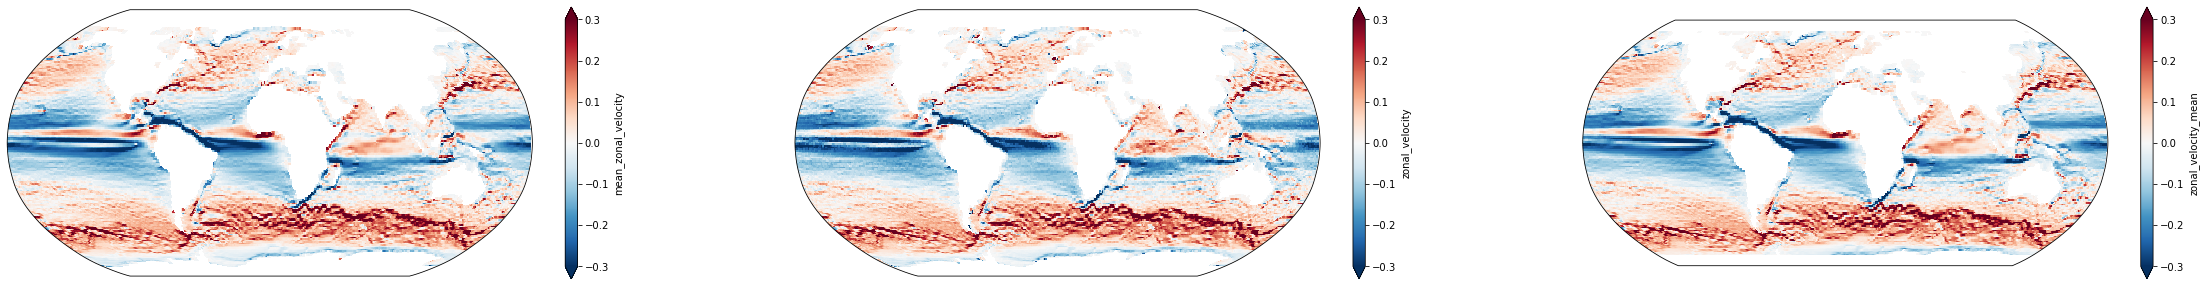

In [47]:
figsize = (40,5)
Vars = [ds_Lstats['mean_zonal_velocity'],ds_Lstats['zonal_velocity'],ds_Estats['zonal_velocity_mean']]
    #crs = ccrs.Mollweide()
crs = ccrs.Robinson()
    #crs = ccrs.EqualEarth()
    #crs = ccrs.Geodetic()

fig = plt.figure(figsize=figsize)
for i,V in zip(range(len(Vars)),Vars):
    ax = fig.add_subplot(str(13)+'%s'%(i+1), projection=crs)
    V.plot(vmax=vmax,y='lat',ax=ax,transform=ccrs.PlateCarree())

    #ax = fig.add_subplot(13, projection=crs)
    #ds_Lstats['mean_zonal_velocity'].plot(vmax=vmax,y='lat',ax=ax,transform=ccrs.PlateCarree())




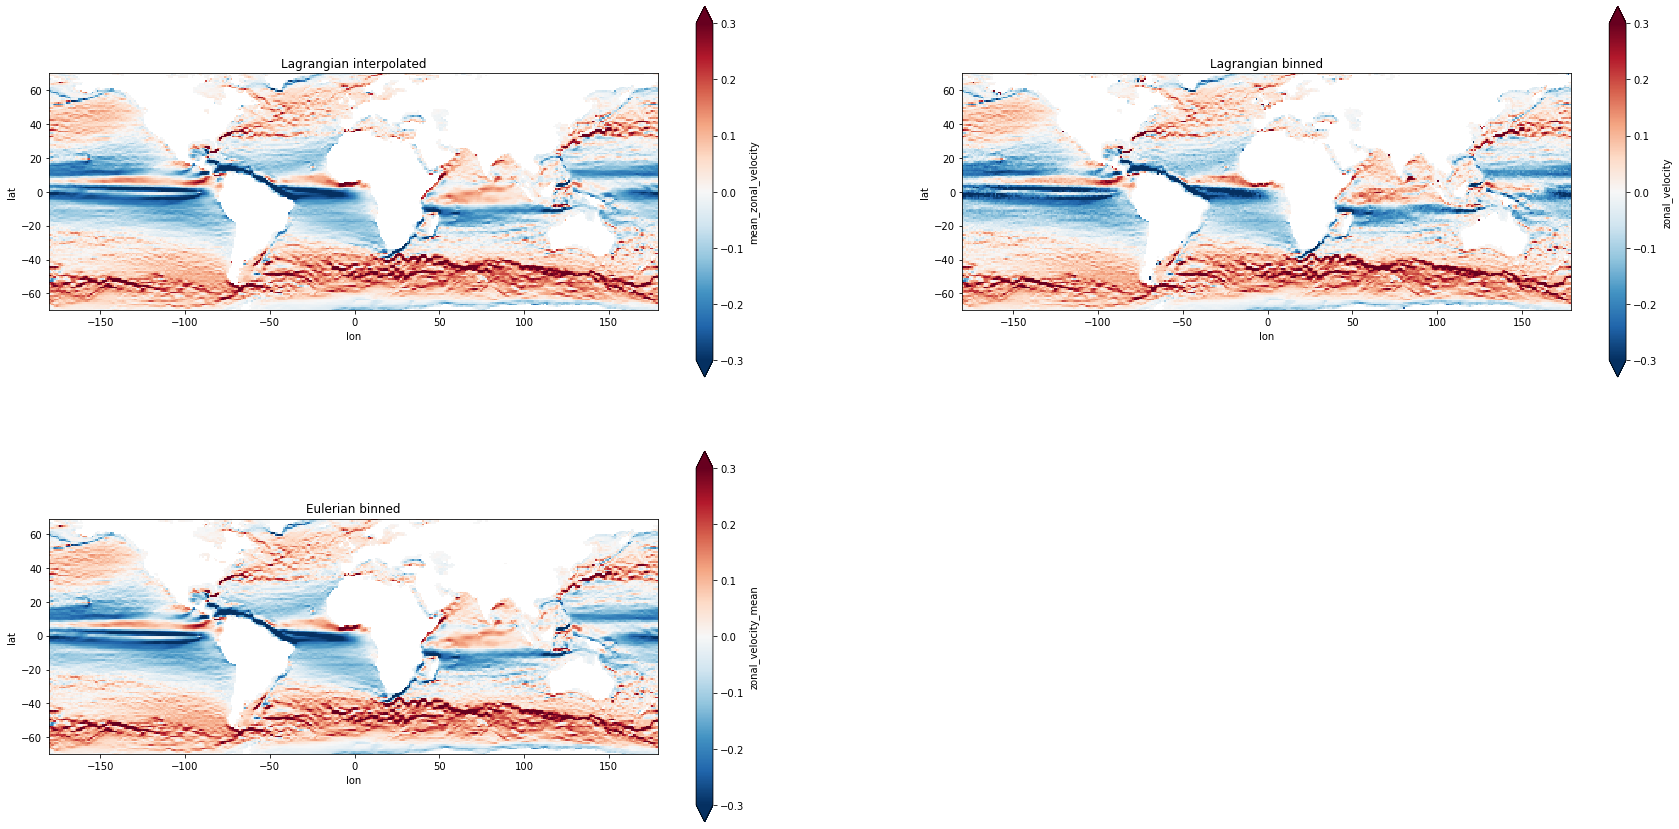

In [62]:
vmax=0.3
fig,axs = plt.subplots(2,2,figsize=(30,15))
ds_Lstats['mean_zonal_velocity'].plot(vmax=vmax,y='lat',ax=axs[0,0])
ds_Lstats['zonal_velocity'].plot(vmax=vmax,y='lat',ax=axs[0,1])
ds_Estats['zonal_velocity_mean'].plot(ax=axs[1,0],vmax=vmax,y='lat')
for ax,title in zip(axs[0,:],['Lagrangian interpolated','Lagrangian binned']):
    ax.set_ylim(-70,70);ax.set_title(title)
    ax.set_aspect('equal')
axs[1,0].set_aspect('equal');axs[1,0].set_title('Eulerian binned')
fig.delaxes(axs[1,1])

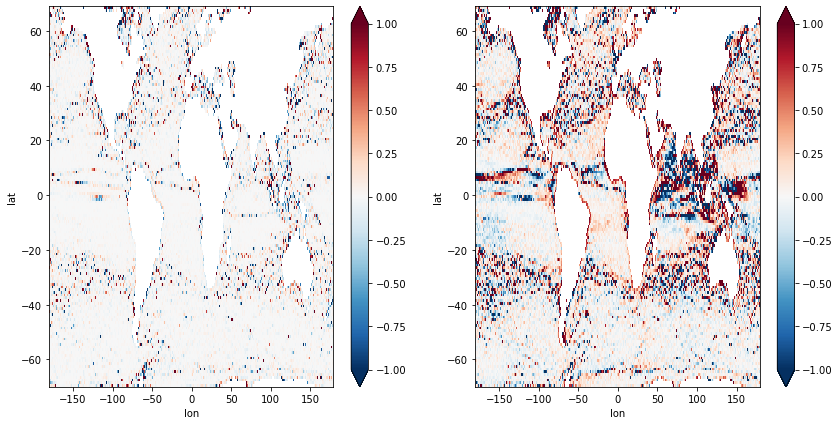

In [64]:
vmax=0.3
fig,ax = plt.subplots(1,2,figsize=(14,7))
((ds_Estats['zonal_velocity_mean']-ds_Lstats['mean_zonal_velocity'])/ds_Estats['zonal_velocity_mean']).plot(vmax=1,y='lat',ax=ax[0])
((ds_Estats['zonal_velocity_mean']-ds_Lstats['zonal_velocity'])/ds_Estats['zonal_velocity_mean']).plot(vmax=1,y='lat',ax=ax[1])

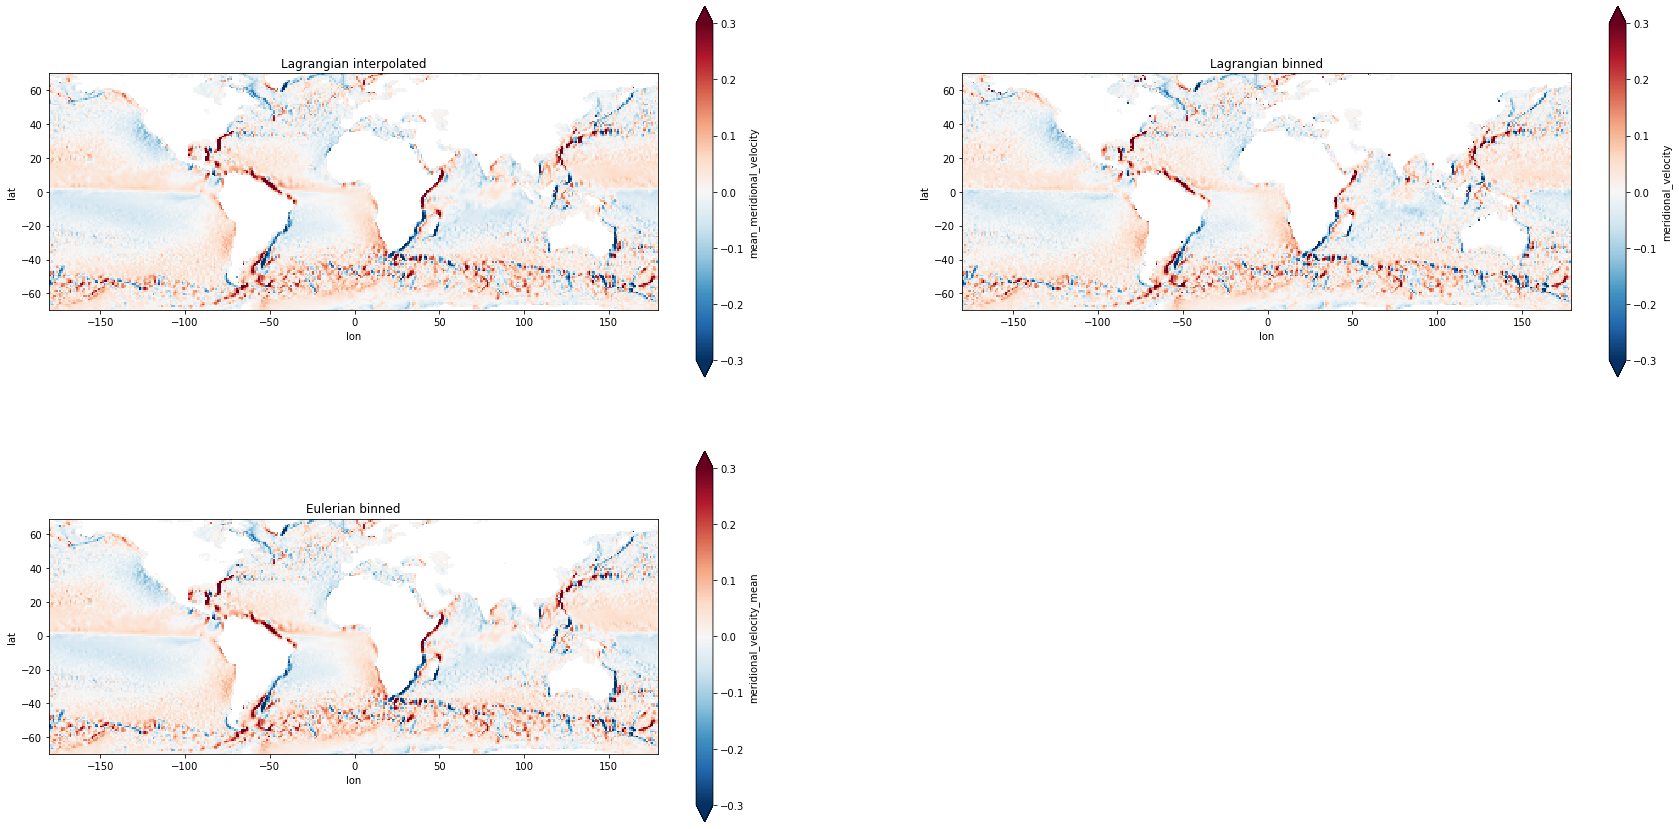

In [74]:
vmax=0.3
fig,axs = plt.subplots(2,2,figsize=(30,15))
ds_Lstats['mean_meridional_velocity'].plot(vmax=vmax,y='lat',ax=axs[0,0])
ds_Lstats['meridional_velocity'].plot(vmax=vmax,y='lat',ax=axs[0,1])
ds_Estats['meridional_velocity_mean'].plot(ax=axs[1,0],vmax=vmax,y='lat')
for ax,title in zip(axs[0,:],['Lagrangian interpolated','Lagrangian binned']):
    ax.set_ylim(-70,70);ax.set_title(title)
    ax.set_aspect('equal')
axs[1,0].set_aspect('equal');axs[1,0].set_title('Eulerian binned')
fig.delaxes(axs[1,1])

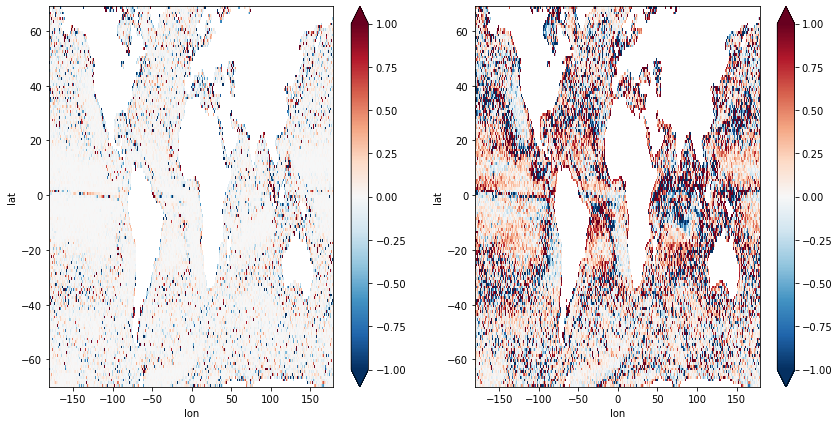

In [75]:
V = 'meridional'
vmax=0.3
fig,ax = plt.subplots(1,2,figsize=(14,7))
((ds_Estats[V+'_velocity_mean']-ds_Lstats['mean_'+V+'_velocity'])/ds_Estats[V+'_velocity_mean']).plot(vmax=1,y='lat',ax=ax[0])
((ds_Estats[V+'_velocity_mean']-ds_Lstats[V+'_velocity'])/ds_Estats[V+'_velocity_mean']).plot(vmax=1,y='lat',ax=ax[1])

In [77]:
ds_Estats['MKE'] = ds_Estats['zonal_velocity_mean']**2+ds_Estats['meridional_velocity_mean']**2

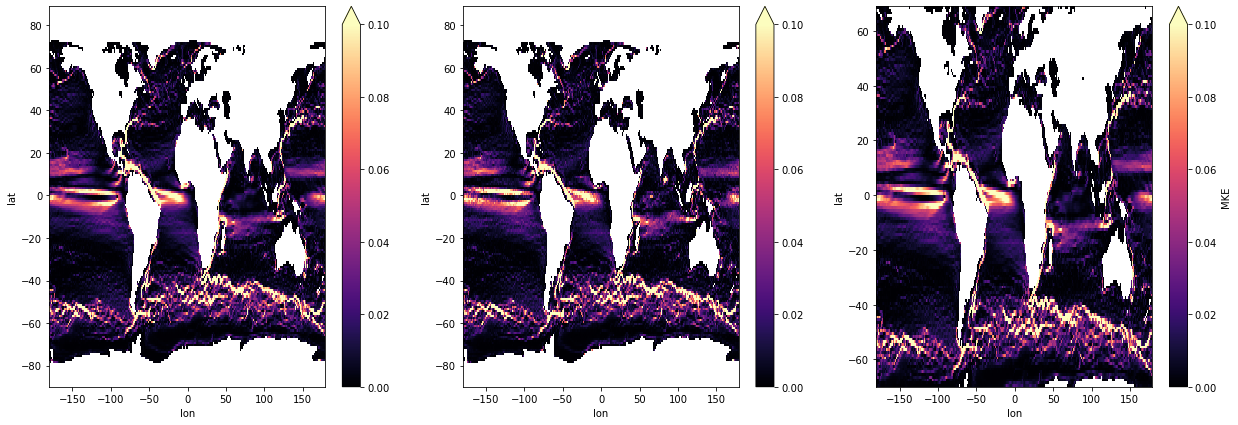

In [79]:
vmax=0.1
fig,ax = plt.subplots(1,3,figsize=(21,7))
(ds_Lstats['mean_zonal_velocity']**2+ds_Lstats['mean_meridional_velocity']**2).plot(vmax=vmax,y='lat',vmin=0,ax=ax[0],cmap='magma')
(ds_Lstats['zonal_velocity']**2+ds_Lstats['meridional_velocity']**2).plot(vmax=vmax,vmin=0,y='lat',ax=ax[1],cmap='magma')

ds_Estats['MKE'].plot(ax=ax[2],vmax=vmax,vmin=0,y='lat',cmap='magma')

In [80]:
MKE_i = ds_Lstats['mean_zonal_velocity']**2+ds_Lstats['mean_meridional_velocity']**2
MKE_b = ds_Lstats['zonal_velocity']**2+ds_Lstats['meridional_velocity']**2

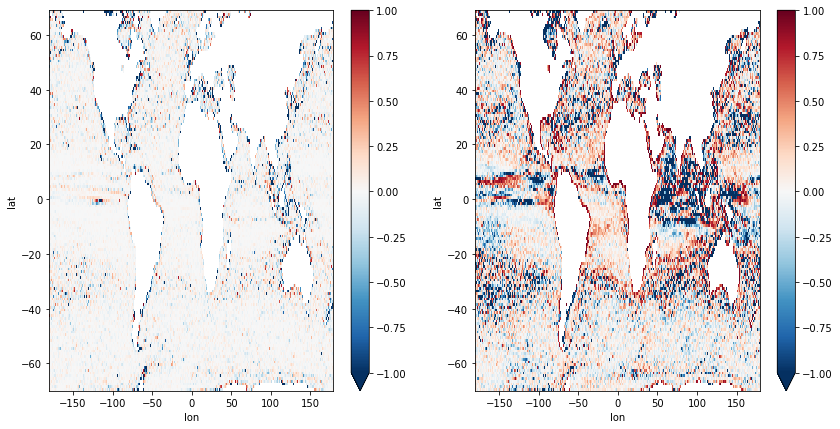

In [81]:
vmax=0.3
fig,ax = plt.subplots(1,2,figsize=(14,7))
((ds_Estats['MKE']-MKE_i)/ds_Estats['MKE']).plot(vmax=1,y='lat',ax=ax[0])
((ds_Estats['MKE']-MKE_b)/ds_Estats['MKE']).plot(vmax=1,y='lat',ax=ax[1])

#### Variance : 
$<(u-\bar u_E)^2>$ $<(u-\bar u_i)^2>$

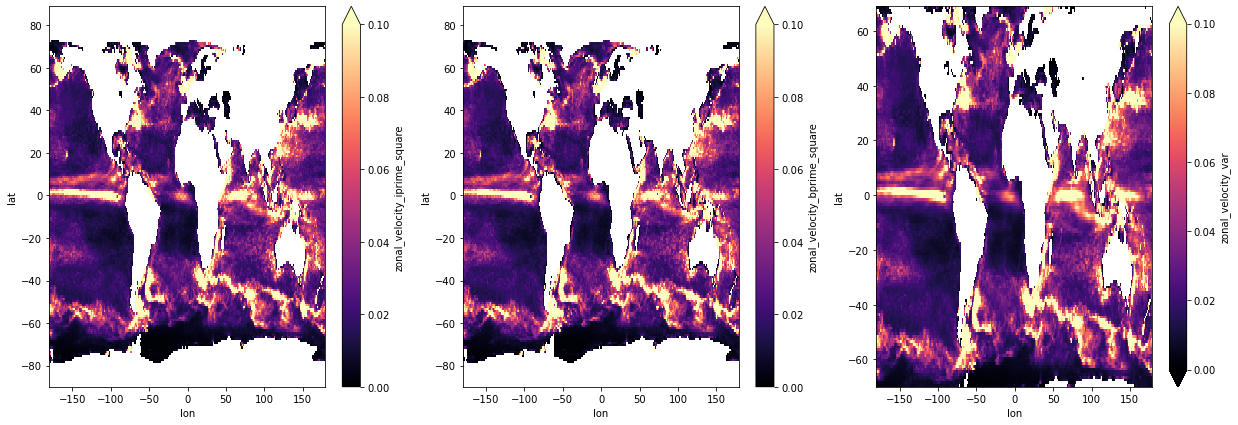

In [84]:
vmax=0.1
fig,ax = plt.subplots(1,3,figsize=(21,7))
ds_Lstats.zonal_velocity_iprime_square.plot(vmax=vmax,y='lat',vmin=0,ax=ax[0],cmap='magma')
ds_Lstats.zonal_velocity_bprime_square.plot(vmax=vmax,vmin=0,y='lat',ax=ax[1],cmap='magma')
ds_Estats['zonal_velocity_var'].plot(ax=ax[2],vmax=vmax,vmin=0,y='lat',cmap='magma')
#ds_Lstats.zonal_velocity_iprime_square.plot(y='lat')

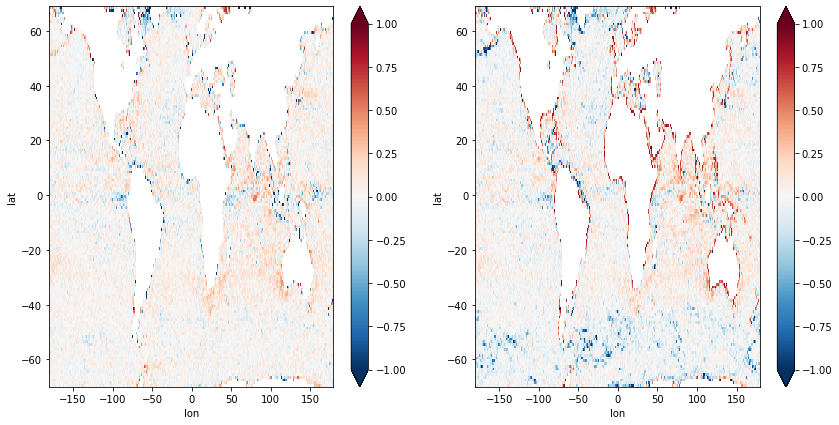

In [85]:
vmax=0.3
fig,ax = plt.subplots(1,2,figsize=(14,7))
((ds_Estats['zonal_velocity_var']-ds_Lstats.zonal_velocity_iprime_square)/ds_Estats['zonal_velocity_var']).plot(vmax=1,y='lat',ax=ax[0])
((ds_Estats['zonal_velocity_var']-ds_Lstats.zonal_velocity_bprime_square)/ds_Estats['zonal_velocity_var']).plot(vmax=1,y='lat',ax=ax[1])

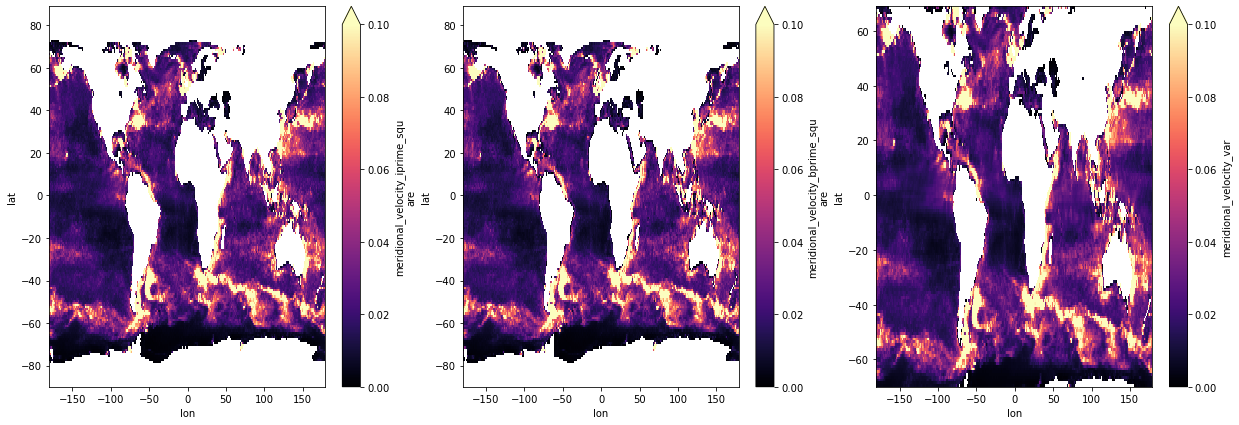

In [86]:
vmax=0.1
fig,ax = plt.subplots(1,3,figsize=(21,7))
ds_Lstats.meridional_velocity_iprime_square.plot(vmax=vmax,y='lat',vmin=0,ax=ax[0],cmap='magma')
ds_Lstats.meridional_velocity_bprime_square.plot(vmax=vmax,vmin=0,y='lat',ax=ax[1],cmap='magma')
ds_Estats['meridional_velocity_var'].plot(ax=ax[2],vmax=vmax,vmin=0,y='lat',cmap='magma')

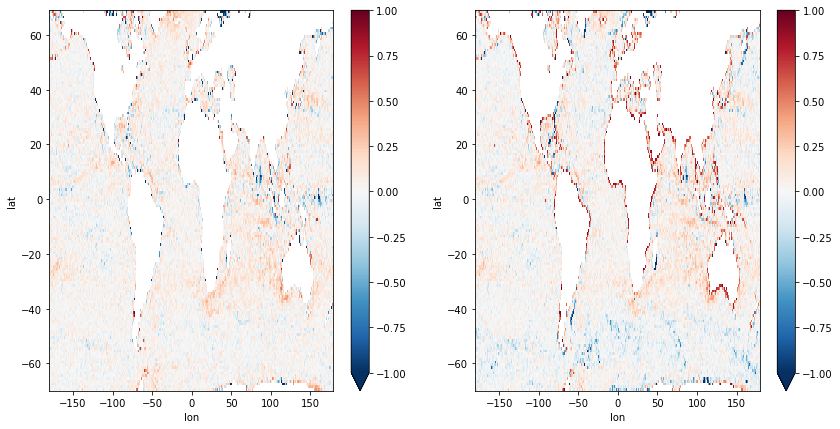

In [87]:
fig,ax = plt.subplots(1,2,figsize=(14,7))
((ds_Estats['meridional_velocity_var']-ds_Lstats.meridional_velocity_iprime_square)/ds_Estats['meridional_velocity_var']).plot(vmax=1,y='lat',ax=ax[0])
((ds_Estats['meridional_velocity_var']-ds_Lstats.meridional_velocity_bprime_square)/ds_Estats['meridional_velocity_var']).plot(vmax=1,y='lat',ax=ax[1])

In [88]:
ds_Estats['EKE'] = ds_Estats['zonal_velocity_var']**2+ds_Estats['meridional_velocity_var']**2

Attention c'est la somme des moyennes des carrés...

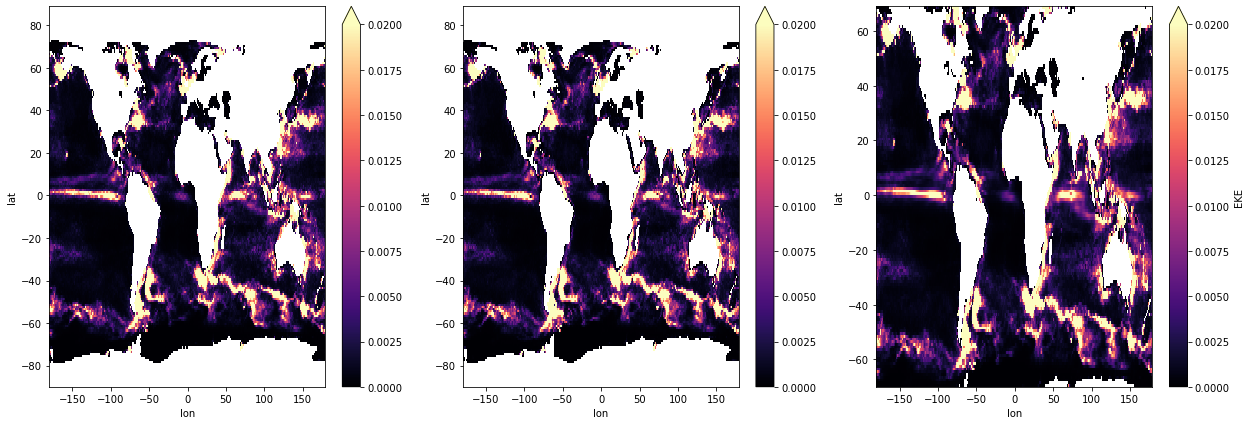

In [94]:
vmax=0.02
fig,ax = plt.subplots(1,3,figsize=(21,7))
(ds_Lstats.zonal_velocity_iprime_square**2+ds_Lstats.meridional_velocity_iprime_square**2).plot(vmax=vmax,y='lat',vmin=0,ax=ax[0],cmap='magma')
(ds_Lstats.zonal_velocity_bprime_square**2+ds_Lstats.meridional_velocity_bprime_square**2).plot(vmax=vmax,vmin=0,y='lat',ax=ax[1],cmap='magma')
ds_Estats['EKE'].plot(ax=ax[2],vmax=vmax,vmin=0,y='lat',cmap='magma')

In [96]:
EKE_i = (ds_Lstats.zonal_velocity_iprime_square**2+ds_Lstats.meridional_velocity_iprime_square**2)
EKE_b = (ds_Lstats.zonal_velocity_bprime_square**2+ds_Lstats.meridional_velocity_bprime_square**2)

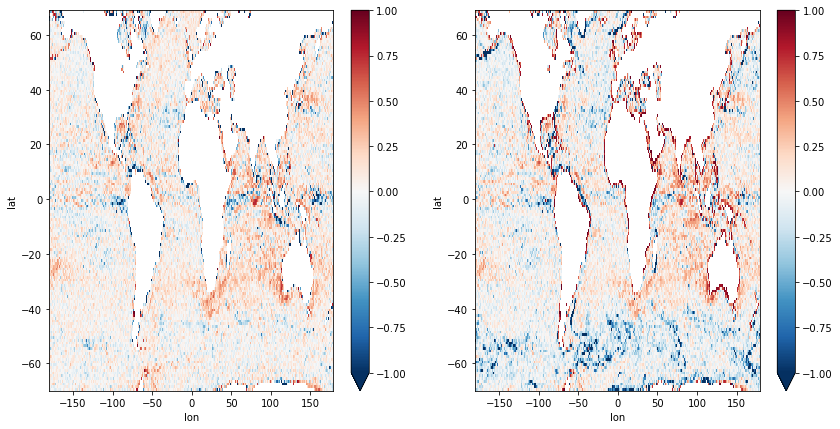

In [97]:
fig,ax = plt.subplots(1,2,figsize=(14,7))
((ds_Estats['EKE']-EKE_i)/ds_Estats['EKE']).plot(vmax=1,y='lat',ax=ax[0])
((ds_Estats['EKE']-EKE_b)/ds_Estats['EKE']).plot(vmax=1,y='lat',ax=ax[1])

AttributeError: 'Dataset' object has no attribute 'EKE_ibinned'

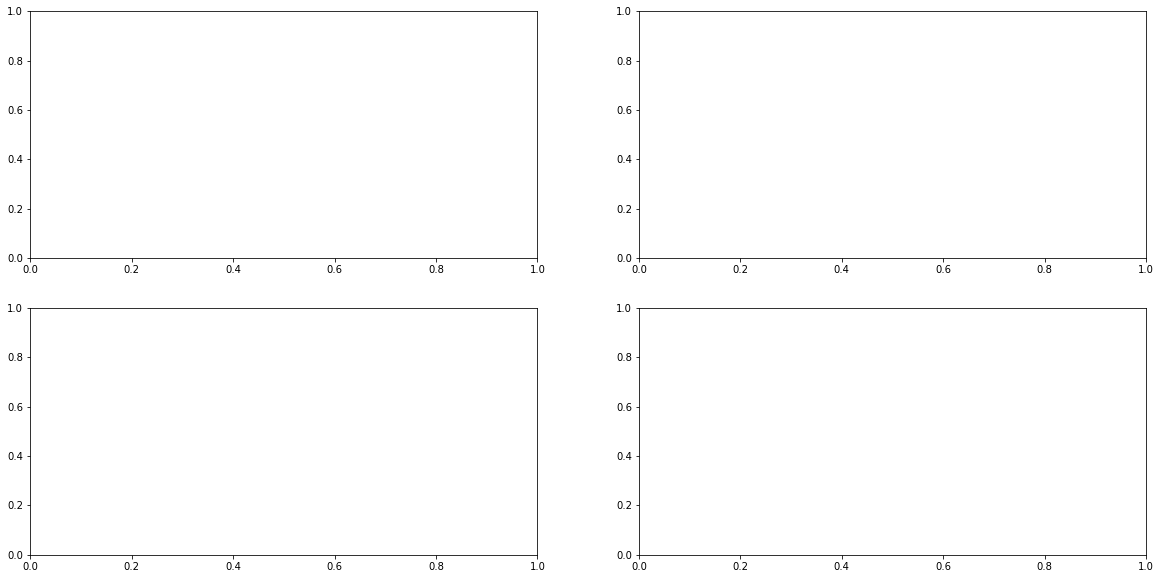

In [90]:
vmax = 0.1
colmap='magma'
fig,ax = plt.subplots(2,2,figsize=(20,10))
(0.5*ds_Lstats.EKE_ibinned).plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[0,0])
ax[0,0].set_aspect('equal');ax[0,0].set_title('Lagrangian mean kinetic energy (interpolated)')
(0.5*ds_Lstats.EKE_binned).plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[0,1])
ax[0,1].set_aspect('equal');ax[0,1].set_title('Lagrangian mean kinetic energy (binned)')
ds_Estats['EKE'].plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[1,0])
ax[1,0].set_aspect('equal');ax[1,0].set_title('Eulerian eddy kinetic energy')
fig.delaxes(ax[1,1])

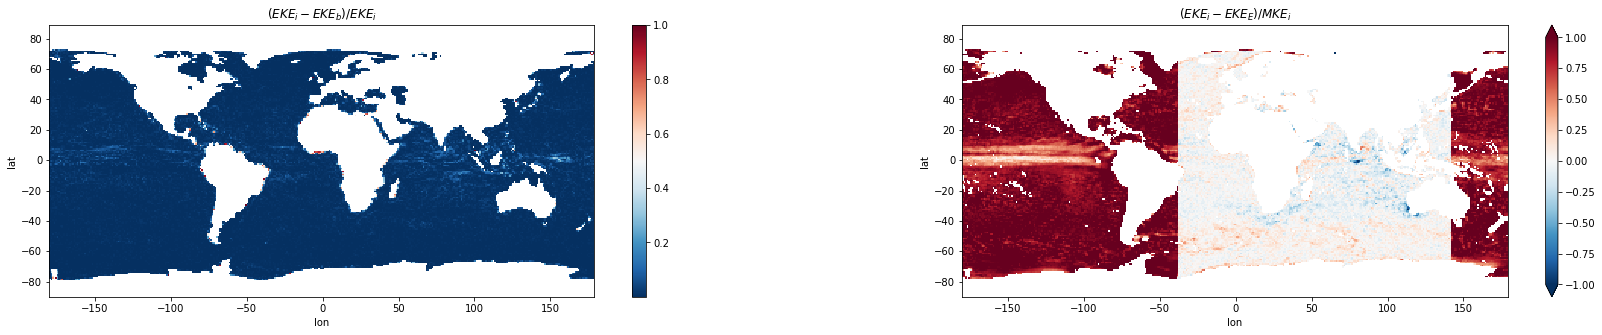

In [14]:
fig,ax = plt.subplots(1,2,figsize=(30,5))
((ds_Lstats.EKE_ibinned-ds_Lstats.EKE_binned)/ds_Lstats.EKE_ibinned).plot(y='lat',vmax=1,cmap='RdBu_r',ax=ax[0])
ax[0].set_title(r'$(EKE_i-EKE_b)/EKE_i$')
((0.5*ds_Lstats.EKE_ibinned-EKE_mean)/(0.5*ds_Lstats.EKE_ibinned)).plot(y='lat',vmax=1,cmap='RdBu_r',ax=ax[1])
ax[1].set_title(r'$(EKE_i-EKE_E)/MKE_i$')
ax[0].set_aspect('equal');ax[1].set_aspect('equal')

In [24]:
p = pa.parcels_output(root_dir+run_name, parquets=['time'])

df_bin = p.load_diagnostic('L_dl1.0_mean_std.zarr')

In [25]:
df_bin

<xarray.Dataset>
Dimensions:                   (lat: 179, lon: 359)
Coordinates:
  * lat                       (lat) float64 -89.5 -88.5 -87.5 ... 86.5 87.5 88.5
  * lon                       (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables: (12/13)
    area                      (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    meridional_velocity_mean  (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    meridional_velocity_std   (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    salinity_mean             (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    salinity_std              (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    sea_level_mean            (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    ...                        ...
    temperature_mean          (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    temperature_std           (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    velocity_amplitude_mean   (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    velocity_amplitude_std    (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    zonal_velocity_mean       (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
    zonal_velocity_std        (lon, lat) float64 dask.array<chunksize=(180, 179), meta=np.ndarray>
Attributes:
    dl:        1.0
    run_name:  global_extra_T365j_dt1j_dij50

### Total kinetic energy : $<\frac{1}{2}(u^2+v^2)>$

In [ ]:
KE = histogram(ds.lon, ds.lat, 
                 bins=[lon, lat], 
                 weights= (0.5*ds.velocity_amplitude), 
                 dim=['i', 'j','face'],
                 block_size=None
                )

KE_mean = (MKE/N).rename('MKE_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})

Text(0.5, 1.0, 'Lagrangian total kinetic energy')

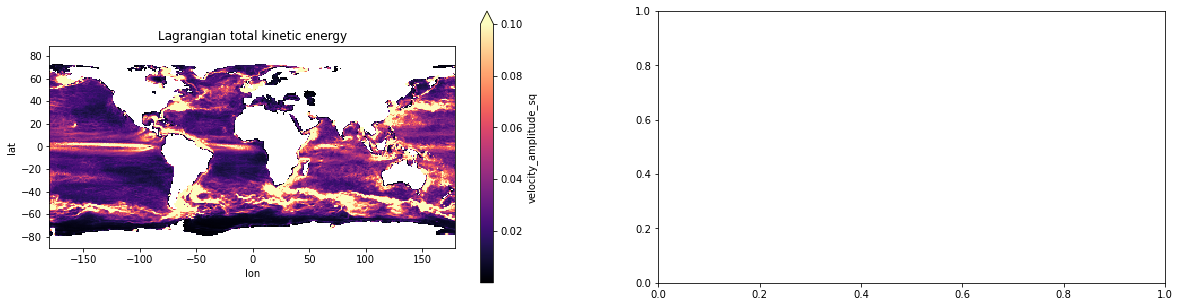

In [28]:
vmax = 0.1
colmap='magma'
fig,ax = plt.subplots(1,2,figsize=(20,5))
(0.5*ds_Lstats.velocity_amplitude_sq).plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[0])
ax[0].set_aspect('equal');ax[0].set_title('Lagrangian total kinetic energy')
#MKE_mean.plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[1,0])
#ax[1,0].set_aspect('equal');ax[1,0].set_title('Eulerian mean kinetic energy')
#fig.delaxes(ax[1,1])

### Eddy kinetic energy : $<\frac{1}{2}(u'^2+v'^2)>$
In Lagrangian perspective, $u'$ can be defined by two methods:

1) Binning, $\bar u_b$ : the velocity aloong drifters trajectory is binned and averaged over time and bins
2) Interpolation of Eulerian field, $\bar u_i$ : the Eulerian field is computed on the model grid and then interpolated over every drifters trajectory

The eddy kinetic energy can be computed in two differents ways:

1) $u-\bar u_b$
2) $u-\bar u_i$

In [ ]:
EKE = histogram(ds.lon, ds.lat, 
                 bins=[lon, lat], 
                 weights= (0.5*ds.zonal_velocity), 
                 dim=['i', 'j','face'],
                 block_size=None
                )

EKE_mean = (MKE/N).rename('MKE_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})

Text(0.5, 1.0, 'Lagrangian eddy kinetic energy (binned)')

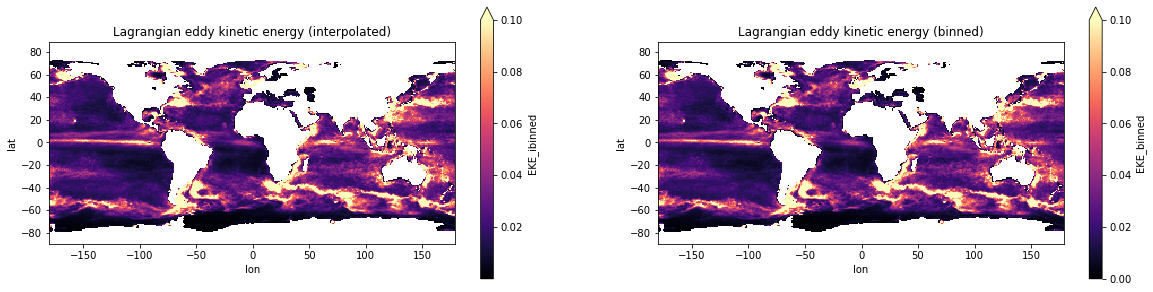

In [15]:
vmax = 0.1
colmap='magma'
fig,ax = plt.subplots(1,2,figsize=(20,5))
(0.5*ds_Lstats.EKE_ibinned).plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[0])
ax[0].set_aspect('equal');ax[0].set_title('Lagrangian eddy kinetic energy (interpolated)')
(0.5*ds_Lstats.EKE_binned).plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[1])
ax[1].set_aspect('equal');ax[1].set_title('Lagrangian eddy kinetic energy (binned)')
#MKE_mean.plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[1,0])
#ax[1,0].set_aspect('equal');ax[1,0].set_title('Eulerian mean kinetic energy')
#ig.delaxes(ax[1,1])

Text(0.5, 1.0, '$(EKE_i-EKE_b)/EKE_i$')

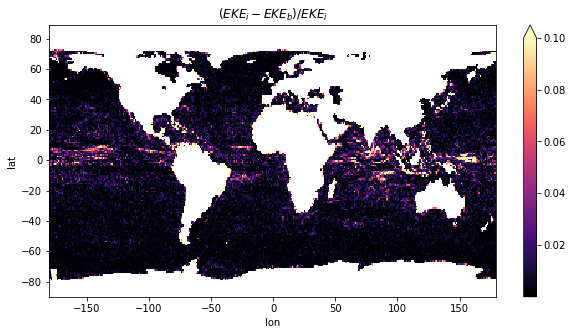

In [21]:
fig,ax = plt.subplots(figsize=(10,5))
((ds_Lstats.EKE_ibinned-ds_Lstats.EKE_binned)/ds_Lstats.EKE_ibinned).plot(y='lat',vmax=0.1,cmap=colmap,ax=ax)
ax.set_title(r'$(EKE_i-EKE_b)/EKE_i$')

In [98]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
